MIT License

Copyright (c) 2018 Udacity

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 0. Clean Up the Zombie Processes
At the end of this notebook, when you execute `env.close()`, it does not clean up the environment completely. Instead, the Unity environment process becomes a "zombie" process. A zombie process is one that has completed execution but still has an entry in the process table because its parent process hasn’t properly reaped it.
You can yourself verify this by running these commands in the terminal. Find the parent process ID (PPID) of the zombie process:
```bash
ps -o pid,ppid,stat,cmd | grep Reacher
```
If the parent process (PPID) is not 1, kill it to clean up the zombie process:
```bash
kill -9 <PPID>
```
Below is the equivalent Python code that checks for and cleans zombie processes using `psutil`. **You need run the cell below only when you restart the Unity environment.** 

> **NOTE**: The code cell below will also kill the Kernel. You should restart it when required.

import psutil

def cleanup_zombie_processes():
    for proc in psutil.process_iter(['pid', 'ppid', 'name', 'status']):
        if proc.info['name'] == 'Reacher_One_Lin' and proc.info['status'] == 'zombie':
            print(f"Zombie process detected: {proc.info}")
            parent = psutil.Process(proc.info['ppid'])
            print(f"Terminating parent process: {parent}")
            parent.terminate()

cleanup_zombie_processes()

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [ ]:
!pip -q install .

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [ ]:
!pip install torch

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    #break
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from unityagents import UnityEnvironment
from ddpg_agent import Agent

In [2]:
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

Found path: /data/Reacher_Linux_NoVis/Reacher.x86_64
Mono path[0] = '/data/Reacher_Linux_NoVis/Reacher_Data/Managed'
Mono config path = '/data/Reacher_Linux_NoVis/Reacher_Data/MonoBleedingEdge/etc'
Preloaded 'libgrpc_csharp_ext.x64.so'
Unable to preload the following plugins:
	libgrpc_csharp_ext.x86.so
Logging to /home/student/.config/unity3d/Unity Technologies/Unity Environment/Player.log


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
env_info = env.reset(train_mode=True)[brain_name]

# size of each action
action_size = brain.vector_action_space_size

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]

agent = Agent(state_size=state_size, action_size=action_size, random_seed = 10)

Episode 100	Average Score: 22.70	Score: 37.03	Total updates 50000
Episode 120	Average Score: 30.12	Score: 38.30	Total updates 60000env was solved within 20 episodes with 100-moving average score of 30.12108932674118


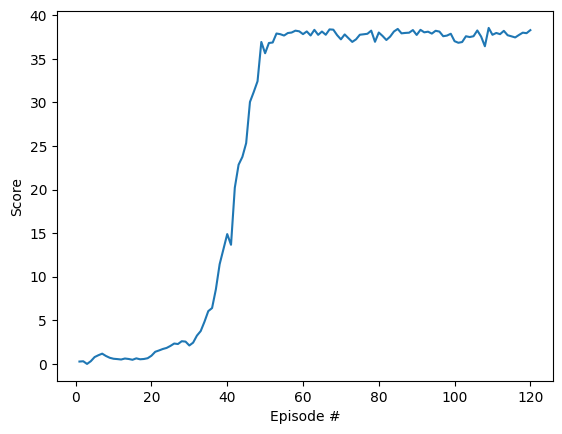

In [4]:
def ddpg(n_episodes=2000, max_t=1000):
    scores_deque = deque(maxlen=100)
    scores = []
    max_score = -np.Inf
    t_counter = 1
    total_updates = 0
    for i_episode in range(1, n_episodes+1):
        #print(f"\r episode number is {i_episode}", end='', flush=True)
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        #state = env.reset()
        agent.reset()
        score = np.zeros(20) 
        for t in range(max_t):
            actions = agent.act(states)

            env_info = env.step(actions)[brain_name]  
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            #scores += env_info.rewards                         # update the score (for each agent)
            #dones_ = env_info.local_done
            #next_state, reward, done, _ = env.step(action)
            agent.update_memory(states, actions, rewards, next_states, dones)
            
            
            if t_counter % 20 == 0:
                for _ in range(10):
                    agent.step()
                    total_updates += 1
            
            states = next_states
            score += env_info.rewards
            t_counter += 1
            
            if True in dones:
                #print("breaking")
                break 
        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}\tTotal updates {}'.format(i_episode, np.mean(scores_deque), np.mean(score),total_updates), end="")
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        
        if len(scores_deque) >= 100 and np.mean(scores_deque) >= 30:
            print(f"\nenv was solved within {i_episode - 100} episodes with 100-moving average score of {np.mean(scores_deque)}")
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
        
    return scores

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()